In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree
import random
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
class BD_search(object):

    def __init__(self):
        self.weight = None
        self.angles = None 
        self.x_train = None
        self.y_train = None
        self.kd_model = None
        self.ball_model = None
        self.is_weight = None
        
        
    def init_angles(self, _angles):
        self.angles = _angles
        self.weight_formula(self.angles)
        
    def weight_formula(self,_θ):
        self.weight = (1 / _θ) * np.exp(-2 * (np.log(_θ / 54)) ** 2)
    
    def brut_force_method(self, _x):
        __x = _x    
        
        n = len(__x)
        m = len(self.y_train[0])
        k = len(self.x_train[0])
        
        _y = np.zeros((n, m))
        _x = np.zeros((n, k))
        for i in tqdm(range(n)):
            mse = np.mean((self.x_train - __x[i]) ** 2 , axis = 1)
            _y[i] = self.y_train[np.argmin(mse),:]
            _x[i] = self.x_train[np.argmin(mse),:]
            
        return _x, _y    
            
    def fit(self, _x, _y, weight = True):
        self.is_weight = weight
        
        __x, __y = np.array(_x), np.array(_y)
        
        if self.is_weight == True:
            self.x_train = __x * self.weight
        else:
            self.x_train = __x
            
        self.y_train = __y
        self.kd_model = KDTree(self.x_train, 10)
        self.ball_model = BallTree(self.x_train, leaf_size=10)
    
    def predict(self, _x, method='kd_tree'):
        _y = []
        __x = []
        
        if self.is_weight == True:
            _x = _x * self.weight
        else:
            _x = _x

        time_one = time.time()

        if method == 'kd_tree':
            dist, ind = self.kd_model.query(_x, k=1)
            ind = np.reshape(ind , -1)
            _y = self.y_train[ind]
            __x = self.x_train[ind]
        
        if method == 'ball_tree':
            dist, ind = self.ball_model.query(_x, k=1)
            ind = np.reshape(ind , -1)
            _y = self.y_train[ind]
            __x = self.x_train[ind]
            
        if method == 'bd_search':
            __x, _y = self.brut_force_method(_x)

        time_two = time.time()
        time_all = (time_two - time_one)
        time_singe = (time_two - time_one) / len(_x)
        print('Полное время решения для датасета: ', time_all)
        print('Время решения для одной частицы: ', time_singe)

        return __x, _y

In [3]:
def regr_model_resume(_y_test, _y_pred, params = ['r','eps', 'n', 'beta'], method='Методы kd_tree, ball_tree и полный перебор \n Тестовые синтетические данные'):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    
    mse = mean_squared_error(_y_pred, _y_test, multioutput='raw_values',squared=True)
    mae = mean_absolute_error(_y_pred, _y_test, multioutput='raw_values')
    r2 = r2_score(_y_pred, _y_test, multioutput='raw_values')
    
    metrics= np.array([mae, mse, r2]).T
    metrics = np.around(metrics, 4)
    
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Метод: {method}', fontsize='20')
    N = len(params)
    M = 2
    for i in range(N):

        plt.subplot(M, N, i + 1)
        plt.title("Корреляционный график")
        plt.xlabel(params[i] + ' Тестовые')
        plt.ylabel(params[i] + ' Предсказанные')
        plt.plot(_y_test[:, i], _y_pred[:, i], '.', alpha = 0.3)
    
    plt.subplot(2, 1, 2)
    ax = plt.gca() 
    fig = plt.gcf()
    
    ax.axis('off')
    table = plt.table(cellText=metrics, colLabels = ['mae', 'rmse', 'r2'], rowLabels = params, loc='center', colWidths=[0.15]*3)
    table.set_fontsize(17)
    table.scale(1,2)
    plt.subplots_adjust(hspace=1.0, wspace=0.5)
    
    plt.show()

In [4]:
def bd_model_resume(_x_test, _x_pred, params = ['r','eps', 'n', 'beta'], _title = '___________', method=''):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    
    rel_mse = mean_squared_error(_x_pred.T, _x_test.T, multioutput='raw_values', squared=False) / mean_squared_error(_x_pred.T* 0, _x_test.T , multioutput='raw_values', squared=False)
    rel_mse = rel_mse.T
    
    plt.figure(figsize=(20, 20))
    plt.suptitle(f'Метод: {method}', fontsize='50')
    N = 9
    
    for i in range(N):
        plt.subplot(3, 3, i + 1)
        plt.title(f"Сравнение индикатрис №{i+1} (Относительный MSE: {rel_mse[i]:.2e})")
        plt.plot(_x_test[i], '*', label = 'Тестовый')
        plt.plot(_x_pred[i], '-', label = 'Ближайший')
        plt.legend()

    plt.show()

In [5]:
df_th = pd.read_csv(r'C:\Users\Kamov\platelets\BD_platelets_regular_1_degre.csv', sep=';')
df_th.head()

,r,eps,n,beta,0,1,2,3,4,5,...,81,82,83,84,85,86,87,88,89,90
0,0.5,0.1,1.3725,40,25.301178,24.938040,23.876934,22.199476,20.031181,17.527292,...,0.011513,0.014099,0.017986,0.023523,0.031062,0.040932,0.053408,0.068672,0.086786,0.107647
1,0.5,0.1,1.3725,42,25.253750,24.898931,23.861731,22.220762,20.097038,17.640442,...,0.040937,0.052109,0.065620,0.081594,0.100038,0.120814,0.143610,0.167922,0.193053,0.218120
2,0.5,0.1,1.3725,44,25.202293,24.855852,23.842764,22.238726,20.160351,17.752266,...,0.116834,0.137759,0.160166,0.183575,0.207347,0.230691,0.252689,0.272336,0.288599,0.300487
3,0.5,0.1,1.3725,46,25.143423,24.805452,23.816780,22.250275,20.218254,17.860188,...,0.226089,0.248032,0.268256,0.285895,0.300072,0.309963,0.314847,0.314183,0.307667,0.295287
4,0.5,0.1,1.3725,48,25.076042,24.746632,23.782681,22.254311,20.269676,17.963202,...,0.316910,0.325093,0.328297,0.326098,0.318296,0.304946,0.286385,0.263235,0.236381,0.206933


In [6]:
df_exp = pd.read_csv(r'C:\Users\Kamov\platelets\experimental_1_degree.csv', sep=';')
df_exp.head()

,10,11,12,13,14,15,16,17,18,19,...,61,62,63,64,65,66,67,68,69,70
0,183.176875,166.478693,134.478772,116.654527,98.472286,78.717751,62.504292,57.866845,49.507113,45.329470,...,3.499498,1.986927,2.974273,1.984659,2.357138,0.593534,-0.434256,-0.257839,-1.024817,NaN
1,74.758799,72.793755,65.249161,66.274876,59.231701,61.344619,52.165751,44.154889,41.012489,34.339016,...,1.738917,1.372427,-0.090051,-0.439739,-0.253310,-0.232650,-1.538535,-0.431494,-0.606203,NaN
2,878.528295,608.147687,422.259021,284.829020,174.500711,104.376918,57.810083,37.118711,28.380340,28.736102,...,-0.362481,0.055591,0.368540,-0.222707,-0.043057,-0.447811,0.499172,0.157822,-0.622346,NaN
3,555.969393,431.583247,345.706680,280.833703,231.427627,179.745473,144.822840,124.502582,94.629270,74.394734,...,-1.668954,-1.835357,-2.323255,-1.719203,0.114578,0.697275,0.605574,0.077802,-2.068405,NaN
4,340.091255,268.053440,213.270653,170.341848,128.769485,95.481732,81.011077,53.541826,36.837450,25.841330,...,3.220378,3.556445,2.990620,-0.043619,0.694566,0.544178,0.696334,0.563298,0.477633,NaN


In [7]:
X_th = df_th[[str(x) for x in range(10,70)]]
Y_th = df_th[['r', 'eps', 'n', 'beta']]

X_exp = df_exp[[str(x) for x in range(10,70)]]


X_th = np.array(X_th)
Y_th = np.array(Y_th)

X_exp = np.array(X_exp)

X_train, X_test, Y_train, Y_test = train_test_split(X_th, Y_th, test_size=0.02, shuffle=True)

angles =  np.array(range(10,70))

In [9]:
Y_scaler =  MinMaxScaler()
Y_scaler.fit(Y_train)

Y_train_scaled = Y_scaler.transform(Y_train)
Y_test_scaled = Y_scaler.transform(Y_test)

In [10]:
serc = BD_search()
serc.init_angles(angles)
serc.fit(X_train, Y_train, weight=True)

In [11]:
x_pred, y_pred = serc.predict(X_test, method='kd_tree')

Полное время решения для датасета:  0.4821047782897949
Время решения для одной частицы:  0.00012289186293392682


In [14]:
x_pred, y_pred = serc.predict(X_test, method='ball_tree')

Полное время решения для датасета:  2.7383484840393066
Время решения для одной частицы:  0.0006980240846391299


In [15]:
x_pred, y_pred = serc.predict(X_test, method='bd_search')

100%|██████████| 3923/3923 [06:25<00:00, 10.18it/s]

Полное время решения для датасета:  385.41304564476013
Время решения для одной частицы:  0.09824446740880961


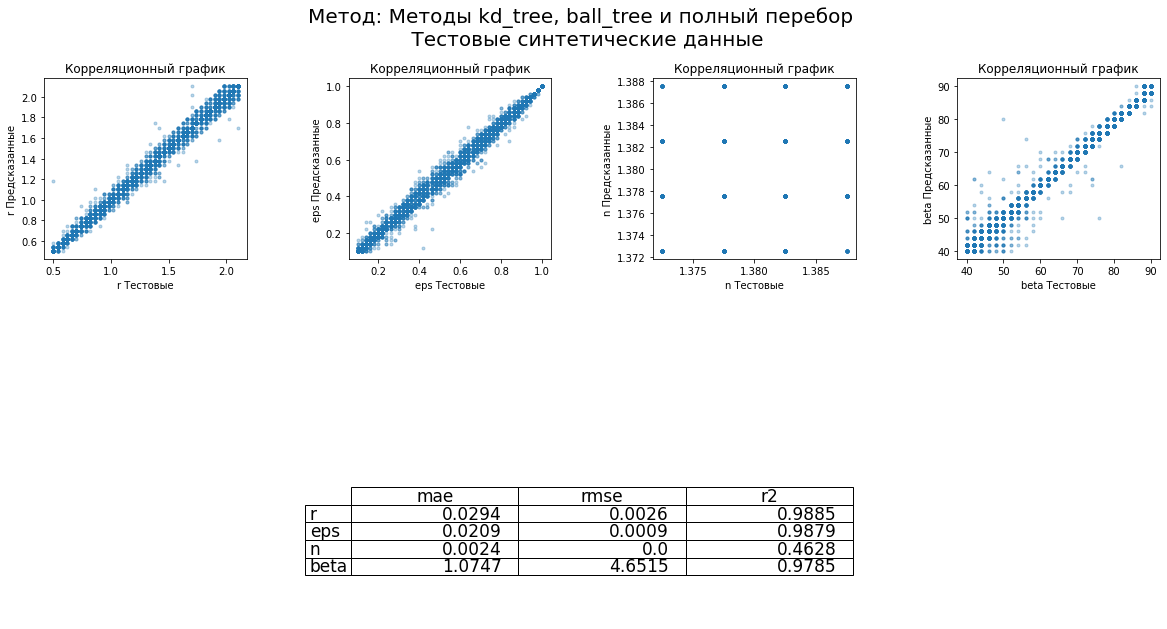

In [12]:
regr_model_resume(y_pred, Y_test, method='Методы kd_tree, ball_tree и полный перебор \n Тестовые синтетические данные')

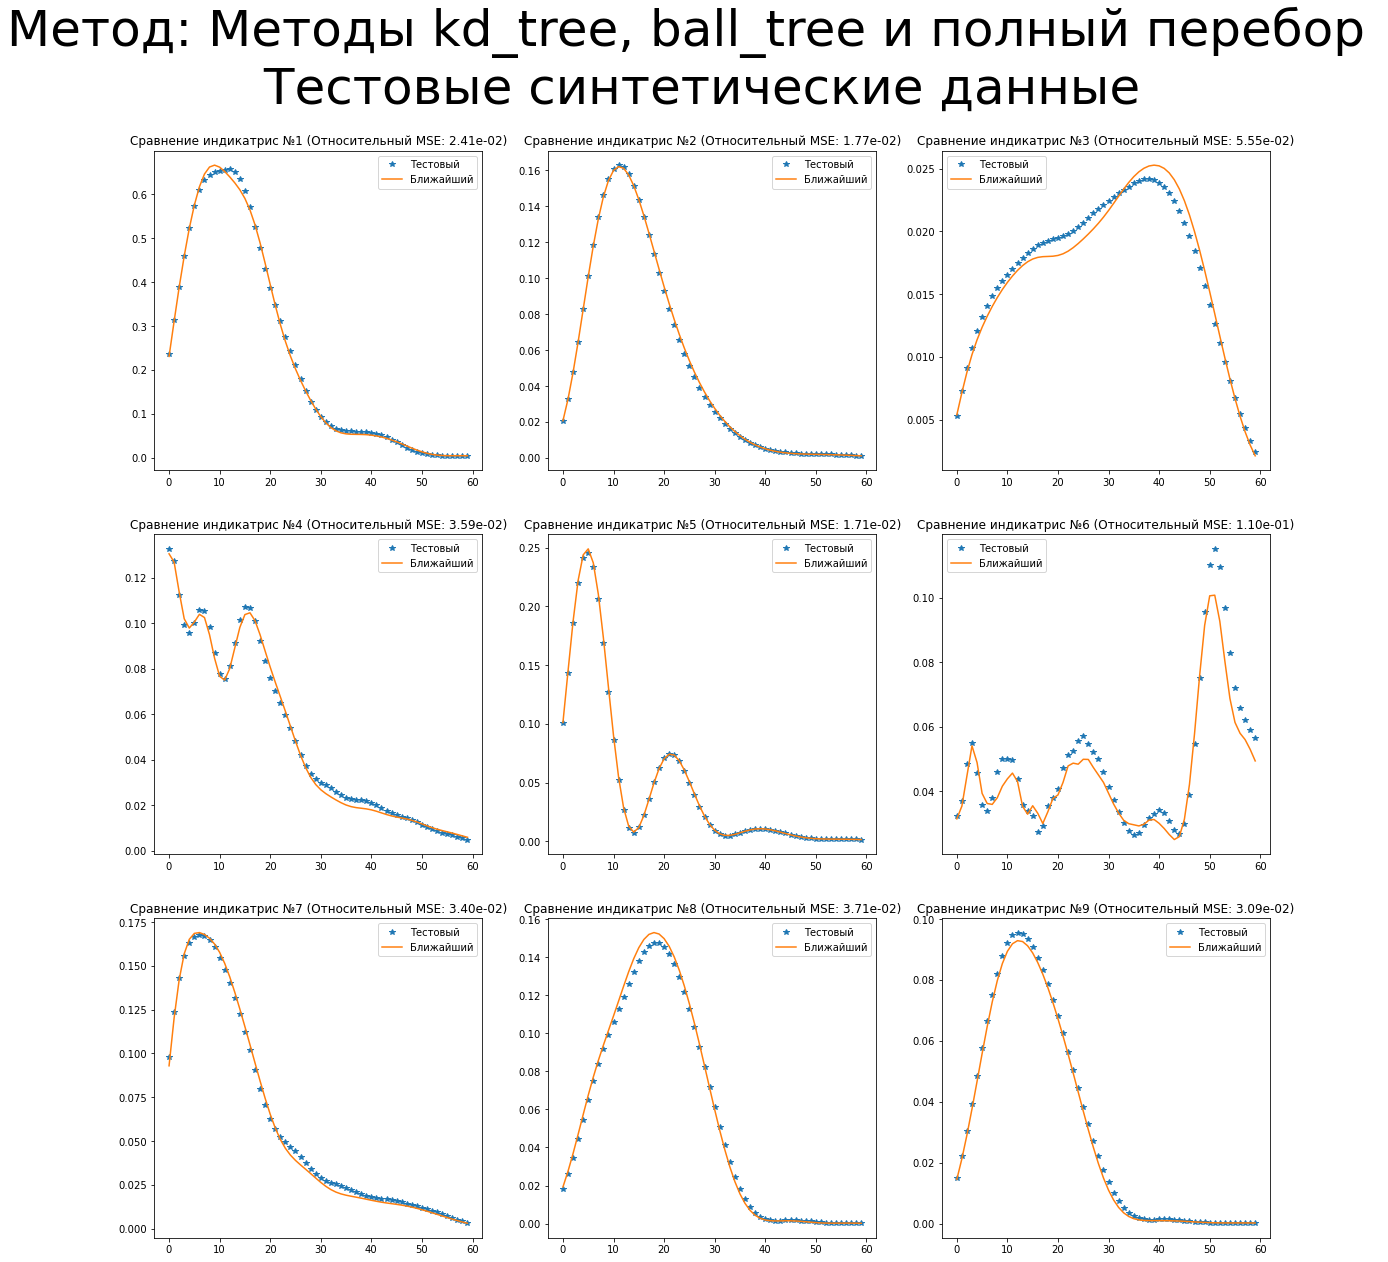

In [13]:
bd_model_resume(X_test * serc.weight, x_pred, method='Методы kd_tree, ball_tree и полный перебор \n Тестовые синтетические данные')

In [16]:
x_pred, y_pred = serc.predict(X_exp, method='kd_tree')

Полное время решения для датасета:  34.517473459243774
Время решения для одной частицы:  0.00197909944723604


In [17]:
x_pred, y_pred = serc.predict(X_exp, method='ball_tree')

Полное время решения для датасета:  25.57400417327881
Время решения для одной частицы:  0.0014663152441533633


In [18]:
x_pred, y_pred = serc.predict(X_exp, method='bd_search')

100%|██████████| 17441/17441 [29:36<00:00,  9.82it/s]

Полное время решения для датасета:  1776.0483403205872
Время решения для одной частицы:  0.10183179521361087


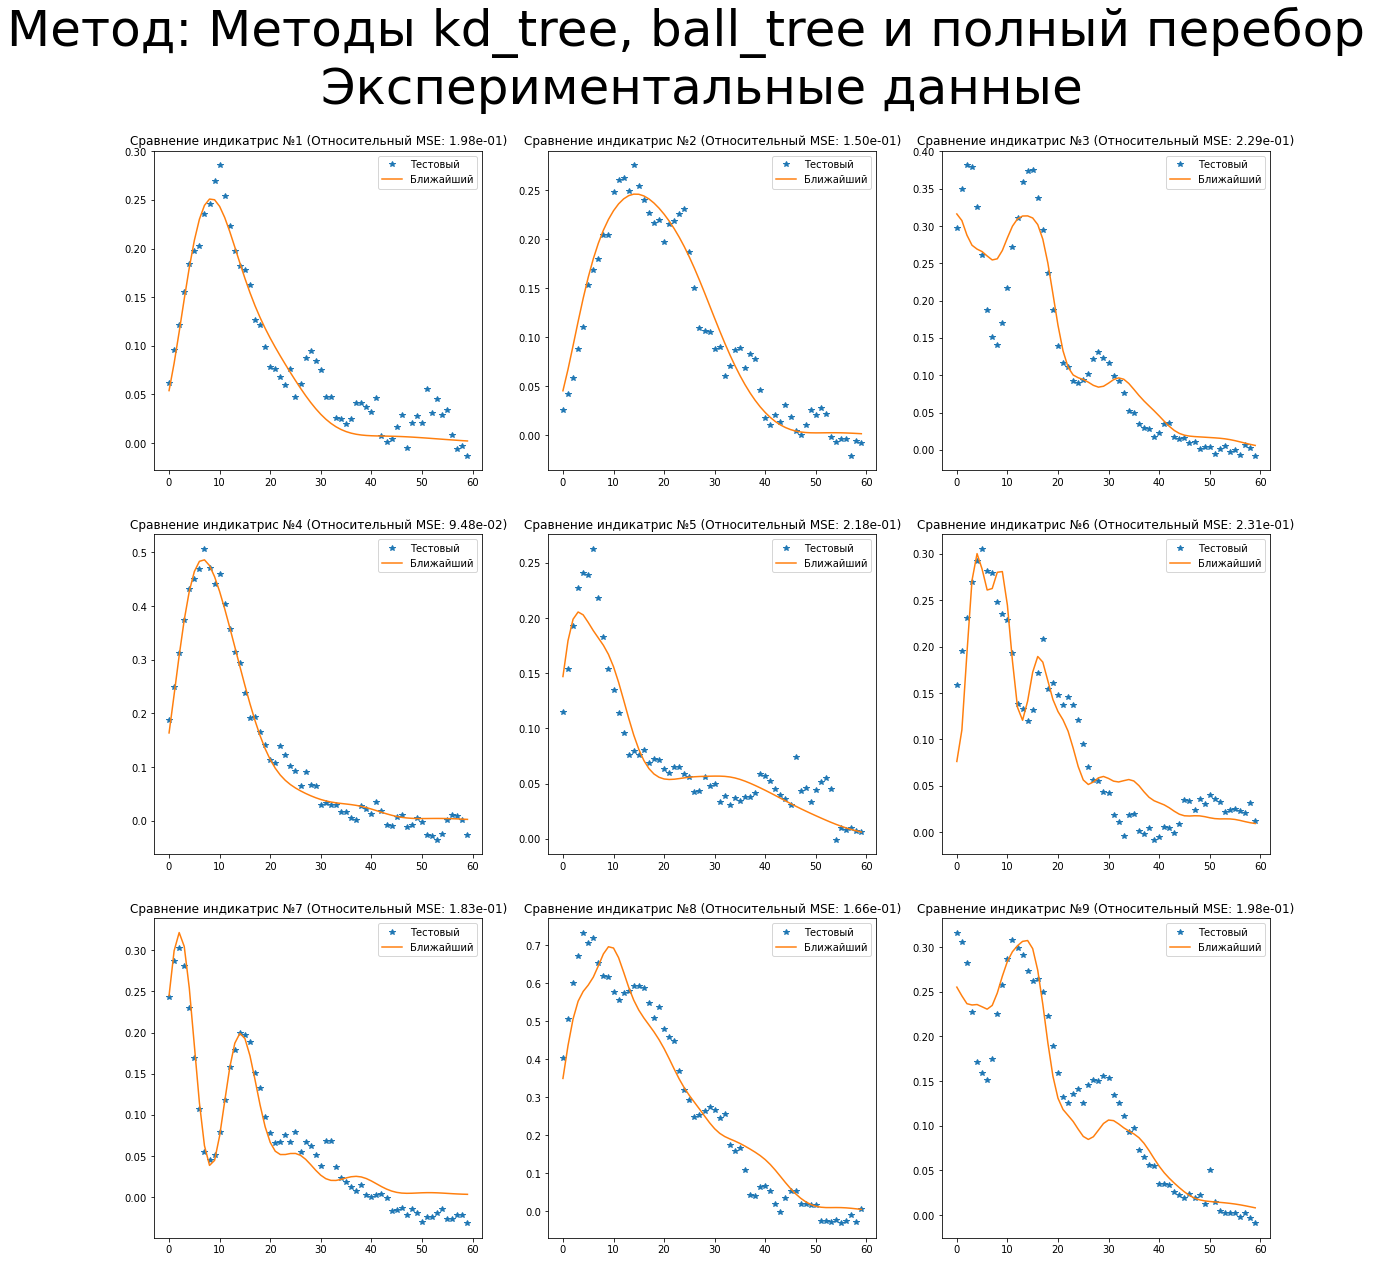

In [20]:
bd_model_resume(X_exp * serc.weight, x_pred, method='Методы kd_tree, ball_tree и полный перебор \n Экспериментальные данные')

In [21]:
def volume_resume(_y_pred):
    vol = 4 / 3 * np.pi * (_y_pred[:,0] ** 3)
    #vol = _y_pred[:,0]
    plt.title("Распредление тромбоцитов по объему")

    plt.ylabel('Количество, у.е.')
    plt.xlabel('Объем тромбоцита, фЛ')
    plt.hist(vol , bins = 20)
    plt.show()

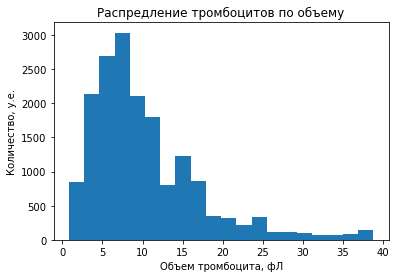

In [22]:
volume_resume(y_pred)